# Setup

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import torch
import time
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error
from tqdm.notebook import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
torch.manual_seed(0)

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])

# Generate Dataset

In [0]:
data, labels = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


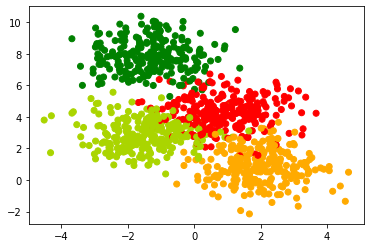

In [0]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape)

(750, 2) (250, 2)


# Using Torch Tensors and Autograd

In [0]:
X_train, X_val, Y_train, Y_val = map(torch.tensor, (X_train, X_val, Y_train, Y_val))

In [0]:
print(X_train.shape, X_val.shape)

torch.Size([750, 2]) torch.Size([250, 2])


In [0]:
def model(x):
    a1 = torch.matmul(x, weights1) + bias1
    h1 = torch.sigmoid(a1)
    a2 = torch.matmul(h1, weights2) + bias2
    h2 = a2.exp() / a2.exp().sum(-1).unsqueeze(-1)
    return h2

In [0]:
def loss_fn(y_hat, y):
    return -(y_hat[range(y.shape[0]), y].log()).mean()

In [0]:
def accuracy(y_hat, y):
    pred = torch.argmax(y_hat, dim=1)
    return (pred == y).float().mean()

In [0]:
import torch.nn.functional as F

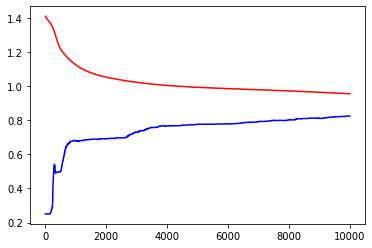

Loss before training 1.4111980199813843
Loss after training 0.9561843276023865


In [0]:
weights1 = torch.randn(2,2)/math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2,4)/math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000

X_train = X_train.float()
Y_train = Y_train.long()

loss_arr = []
acc_arr = []

for epoch in range(epochs):
    y_hat = model(X_train)
    loss = F.cross_entropy(y_hat, Y_train)
    loss.backward()
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))

    with torch.no_grad():
        weights1 -= weights1.grad * learning_rate
        bias1 -= bias1.grad * learning_rate
        weights2 -= weights2.grad * learning_rate
        bias2 -= bias2.grad * learning_rate
        weights1.grad.zero_()
        bias1.grad.zero_()
        weights2.grad.zero_()
        bias2.grad.zero_()

plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b-')
plt.show()
print('Loss before training', loss_arr[0])
print('Loss after training', loss_arr[-1])

# Using torch.nn

In [0]:
import torch.nn as nn

In [0]:
class torch_ffnn(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.weights1 = nn.Parameter(torch.randn(2,2)/math.sqrt(2))
        self.bias1 = nn.Parameter(torch.zeros(2))
        self.weights2 = nn.Parameter(torch.randn(2,4)/math.sqrt(2))
        self.bias2 = nn.Parameter(torch.zeros(4))

    def forward(self, X):
        a1 = torch.matmul(X, self.weights1) + self.bias1
        h1 = a1.sigmoid()
        a2 = torch.matmul(h1, self.weights2) + self.bias2
        h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
        return h2

In [0]:
def fit(epochs=1000, learning_rate=1):
    loss_arr = []
    acc_arr= []
    for epoch in range(epochs):
        y_hat = fn(X_train)
        loss = F.cross_entropy(y_hat, Y_train)
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat, Y_train))

        loss.backward()
        with torch.no_grad():
            for param in fn.parameters():
                param -= learning_rate * param.grad
            fn.zero_grad()
    
    plt.plot(loss_arr, 'r-')
    plt.plot(acc_arr, 'b-')
    plt.show()
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])

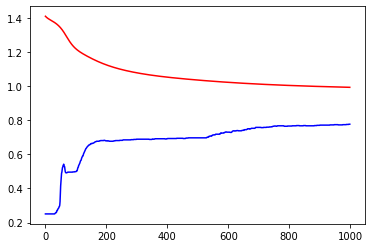

Loss before training 1.4111980199813843
Loss after training 0.9939236640930176


In [0]:
fn = torch_ffnn()
fit()

# Using nn.Linear and Optim

In [0]:
class torch_ffnn_v1(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.lin1 = nn.Linear(2,2)
        self.lin2 = nn.Linear(2,4)
    
    def forward(self, X):
        a1 = self.lin1(X)
        h1 = torch.sigmoid(a1)
        a2 = self.lin2(h1)
        h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
        return h2

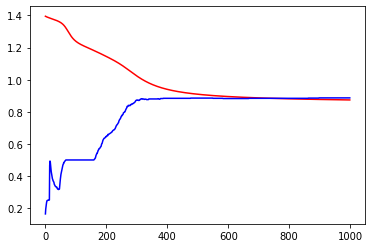

Loss before training 1.395160436630249
Loss after training 0.8738410472869873


In [0]:
fn = torch_ffnn_v1()
fit()

In [0]:
from torch import optim

In [0]:
def fit_v1(epochs=1000, learning_rate=1):
    loss_arr = []
    acc_arr = []
    opt = optim.SGD(fn.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        y_hat = fn(X_train)
        loss = F.cross_entropy(y_hat, Y_train)
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat, Y_train))

        loss.backward()
        opt.step()
        opt.zero_grad()

    plt.plot(loss_arr, 'r-')
    plt.plot(acc_arr, 'b-')
    plt.show()
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])

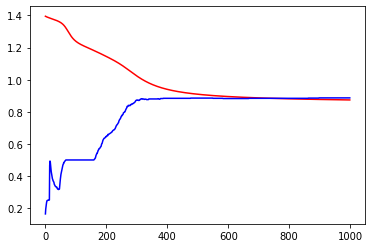

Loss before training 1.395160436630249
Loss after training 0.8738410472869873


In [0]:
fn = torch_ffnn_v1()
fit_v1()

# Using nn.Sequential

In [0]:
class torch_ffnn_v2(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net = nn.Sequential(
            nn.Linear(2,2),
            nn.Sigmoid(),
            nn.Linear(2,4),
            nn.Softmax()
        )

    def forward(self, X):
        return self.net(X)

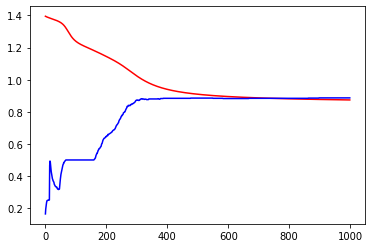

Loss before training 1.395160436630249
Loss after training 0.8738409876823425


In [0]:
fn = torch_ffnn_v2()
fit_v1()

In [0]:
def fit_v2(x, y, model, opt, loss_fn, epochs=1000):

    for epoch in range(epochs):
        loss = loss_fn(model(x), y)

        loss.backward()
        opt.step()
        opt.zero_grad()

    plt.plot(loss_arr, 'r-')
    plt.plot(acc_arr, 'b-')
    plt.show()
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])

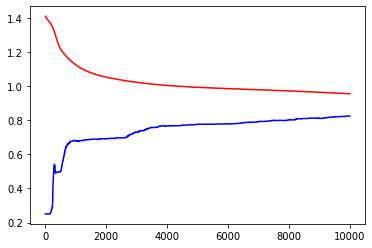

Loss before training 1.4111980199813843
Loss after training 0.9561843276023865


In [0]:
fn = torch_ffnn_v2()
opt = optim.SGD(fn.parameters(), lr=1)
loss_fn = F.cross_entropy
fit_v2(X_train, Y_train, model=fn, opt=opt, loss_fn=loss_fn, epochs=2000)